In [1]:
import os
import sys

MASK_RCNN = "/data2/tmps/object-masking/modules/mask_rcnn"
if MASK_RCNN not in sys.path:
    sys.path.insert(0, MASK_RCNN)

In [2]:
import random
import tensorflow as tf
import matplotlib.pyplot as plt

import visualize
import utils
import model as modellib
from model import log

import balloon

Using TensorFlow backend.


In [3]:
def get_ax(rows=1, cols=1, size=16):
    """Provide a central point to control graph sizes.
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Configurations

In [4]:
config = balloon.BalloonConfig()

class InferenceConfig(config.__class__):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()

DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0
TEST_MODE = "inference"  # 'inference' or 'training'
MODEL_DIR = "tmps/logs"  # Directory to save logs and trained model
BALLON_WEIGHTS_PATH = "tmps/mask_rcnn_balloon.h5"  # TODO: update this path
BALLOON_DIR = "tmps/balloon"


Configurations:
BACKBONE                       resnet101
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           balloon
NUM_CLASSES                    2
POOL_SIZE  

## Load Validation Dataset

In [5]:
# Load validation dataset
dataset = balloon.BalloonDataset()
dataset.load_balloon(BALLOON_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 13
Classes: ['BG', 'balloon']


## Load Model

In [6]:
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

In [7]:
# Or, load the last model you trained
#weights_path = model.find_last()[1]
weights_path = BALLON_WEIGHTS_PATH

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  tmps/mask_rcnn_balloon.h5


## Run Detection

image ID: balloon.5555705118_3390d70abe_b.jpg (7) tmps/balloon/val/5555705118_3390d70abe_b.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max: 1024.00000


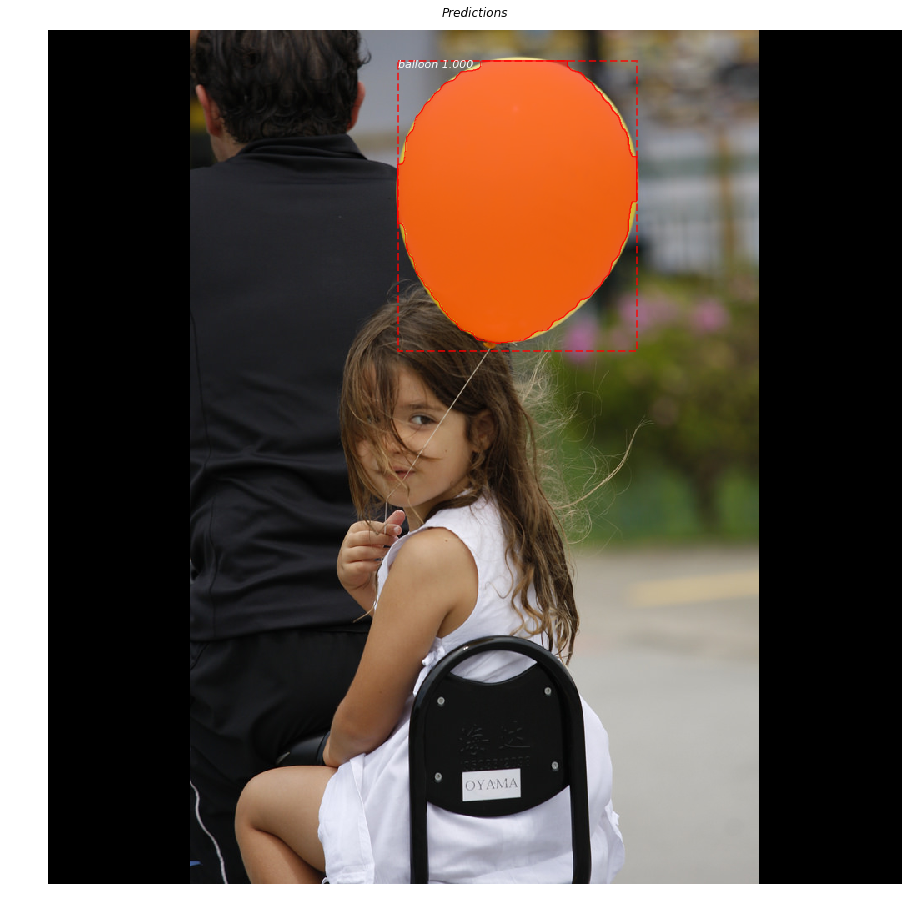

gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000
gt_bbox                  shape: (1, 4)                min:   33.00000  max:  706.00000
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000


In [8]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(
    info["source"], info["id"], image_id, dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

## Color Splash

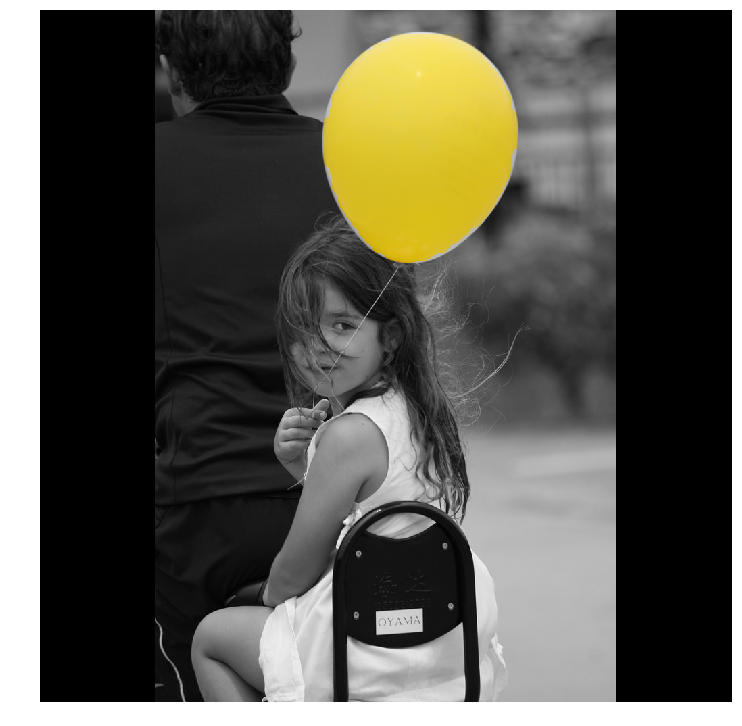

In [9]:
splash = balloon.color_splash(image, r['masks'])
visualize.display_images([splash], cols=1)